# TaRGET Project CC RNA-seq TPM and RPKM Data Processing Construction

__Author:__ Bryan Quach  
__Date:__ April 24, 2017

## Objective

### Estimated Analysis Time: <1 day*

Using single-end RNA-seq data from the TaRGET project Collaborative Cross (CC) mice, the goal of this analysis is to create R data objects containing transcripts per million (TPM) values that will be used for downstream eQTL analysis. We will additionally create objects containing FPKM (Fragments per Kilobase Million reads mapped) data in case this is needed for later use.

**This estimate optimistically assumes that the analysis will be done as shown below without interruption, with an internet connection with high speed data transfer rates, and with all necessary software already installed. Limitations in internet data transfer rates and software installation can significantly increase analysis time.*

## Analysis Outline

The analysis can be roughly divided into the following steps:

* Data retrieval and wrangling
* TPM and FPKM data consolidation
* TPM and FPKM data exploration

## R Packages

In addition to the base packages, we use the following R packages in this analysis:

* [tximport](http://bioconductor.org/packages/release/bioc/html/tximport.html)

## Data retrieval and wrangling

In [ ]:
#Create data directories and retrieve all gene expression quantification files
system("rm -r data/")
system("mkdir data")
system("mkdir data/tamu") #TAMU subdirectory
system("mkdir data/tamu_htsf") #Merged data from TAMU and HTSF subdirectory
system("scp killdevil.unc.edu:/proj/fureylab/data/RNA-seq/mouse/CC/CC*/*/*genes.results data/")

In [ ]:
#Rename TAMU-related files and move them to a subdirectory
move.cmds <- c(
    "mv data/Rusyn-Lung-133.genes.results data/tamu/LUNG_CC133-BD_study_1500ppm_LUNG_CC_133.genes.results",
    "mv data/Rusyn-Lung-50.genes.results data/tamu/LUNG_CC50-BD_study_1500ppm_LUNG_CC_50.genes.results",
    "mv data/Rusyn-Lung-40.genes.results data/tamu/LUNG_CC40-BD_study_625ppm_LUNG_CC_40.genes.results",
    "mv data/Rusyn-Lung-65.genes.results data/tamu/LUNG_CC65-BD_study_1500ppm_LUNG_CC_65.genes.results",
    "mv data/Rusyn-Lung-57.genes.results data/tamu/LUNG_CC57-BD_study_1500ppm_LUNG_CC_57.genes.results",
    "mv data/Rusyn-Lung-33.genes.results data/tamu/LUNG_CC33-BD_study_625ppm_LUNG_CC_33.genes.results",
    "mv data/Rusyn-Lung-117.genes.results data/tamu/LUNG_CC117-BD_study_625ppm_LUNG_CC_117.genes.results",
    "mv data/Rusyn-Lung-19.genes.results data/tamu/LUNG_CC19-BD_study_0ppm_LUNG_CC_19.genes.results",
    "mv data/Rusyn-Lung-72.genes.results data/tamu/LUNG_CC72-BD_study_1500ppm_LUNG_CC_72.genes.results",
    "mv data/Rusyn-Lung-32.genes.results data/tamu/LUNG_CC32-BD_study_625ppm_LUNG_CC_32.genes.results",
    "mv data/Rusyn-Lung-76.genes.results data/tamu/LUNG_CC76-BD_study_0ppm_LUNG_CC_76.genes.results",
    "mv data/Rusyn-Lung-75.genes.results data/tamu/LUNG_CC75-BD_study_0ppm_LUNG_CC_75.genes.results",
    "mv data/Rusyn-Lung-119.genes.results data/tamu/LUNG_CC119-BD_study_625ppm_LUNG_CC_119.genes.results",
    "mv data/Rusyn-Liver-34.genes.results data/tamu/LIVER_CC34-BD_study_625ppm_LIVER_CC_34.genes.results",
    "mv data/Rusyn-Kidney-90.genes.results data/tamu/KIDNEY_CC90-BD_study_0ppm_KIDNEY_CC_90.genes.results",
    "mv data/Rusyn-Kidney-41.genes.results data/tamu/KIDNEY_CC41-BD_study_625ppm_KIDNEY_CC_41.genes.results",
    "mv data/Rusyn-Kidney-120.genes.results data/tamu/KIDNEY_CC120-BD_study_625ppm_KIDNEY_CC_120.genes.results",
    "mv data/Rusyn-Kidney-124.genes.results data/tamu/KIDNEY_CC124-BD_study_625ppm_KIDNEY_CC_124.genes.results",
    "mv data/Rusyn-Kidney-123.genes.results data/tamu/KIDNEY_CC123-BD_study_625ppm_KIDNEY_CC_123.genes.results")

for(cmd in move.cmds){ system(cmd) }

#Rename merged file and move it into a subdirectory
system("mv data/LUNG_CC37-BD_study_625ppm_LUNG_CC_37_htsf_tamu_merged.genes.results data/tamu_htsf/LUNG_CC37-BD_study_625ppm_LUNG_CC_37.genes.results")

#Rename all files to be more concise
files <- list.files("data/", pattern="genes.results")
for(file in files){
    name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
    name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
    prefix <- paste(name.data, sep="", collapse="_")
    new.file <- paste("data/", prefix, "_htsf.genes.results", sep="")
    cmd <- paste("mv", paste("data/", file, sep=""), new.file, sep=" ")
    system(cmd)
}

files <- list.files("data/tamu", pattern="genes.results")
for(file in files){
    name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
    name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
    prefix <- paste(name.data, sep="", collapse="_")
    new.file <- paste("data/tamu/", prefix, "_tamu.genes.results", sep="")
    cmd <- paste("mv", paste("data/tamu/", file, sep=""), new.file, sep=" ")
    system(cmd)
}

file="LUNG_CC37-BD_study_625ppm_LUNG_CC_37.genes.results"
name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
prefix <- paste(name.data, sep="", collapse="_")
new.file <- paste("data/tamu_htsf/", prefix, "_merged.genes.results", sep="")
cmd <- paste("mv", paste("data/tamu_htsf/", file, sep=""), new.file, sep=" ")
system(cmd)

## Count matrix construction

We need to produce a matrix of TPM values and FPKM values where each row is a gene and each column is a sample. To do this we use the `tximport` R package. The object we create will contain more than just these matrices, but the function `abundance`

In [2]:
library(tximport)

In [6]:
#Prepare file list
files.htsf <- file.path("data", list.files("data/", pattern="genes.results"))
files.tamu <- file.path("data", "tamu", list.files("data/tamu", pattern="genes.results"))
files.merged <- file.path("data", "tamu_htsf", list.files("data/tamu_htsf", pattern="genes.results"))
names(files.htsf) <- basename(sapply(strsplit(files.htsf, '.', fixed=T), function(x){x[1]}))
names(files.tamu) <- basename(sapply(strsplit(files.tamu, '.', fixed=T), function(x){x[1]}))
names(files.merged) <- basename(sapply(strsplit(files.merged, '.', fixed=T), function(x){x[1]}))

#Import data with TPM as the abundance values
txi.rsem.htsf <- tximport(files.htsf, txIn=F, abundanceCol="TPM", geneIdCol="gene_id", countsCol="expected_count", lengthCol="effective_length", importer=read.delim)
txi.rsem.tamu <- tximport(files.tamu, txIn=F, abundanceCol="TPM", geneIdCol="gene_id", countsCol="expected_count", lengthCol="effective_length", importer=read.delim)
txi.rsem.merged <- tximport(files.merged, txIn=F, abundanceCol="TPM", geneIdCol="gene_id", countsCol="expected_count", lengthCol="effective_length", importer=read.delim)
save(list=c("txi.rsem.htsf","txi.rsem.tamu","txi.rsem.merged"), file="tpm_data.original.Rdata")

#Import data with FPKM as the abundance values
txi.rsem.htsf <- tximport(files.htsf, txIn=F, abundanceCol="FPKM", geneIdCol="gene_id", countsCol="expected_count", lengthCol="effective_length", importer=read.delim)
txi.rsem.tamu <- tximport(files.tamu, txIn=F, abundanceCol="FPKM", geneIdCol="gene_id", countsCol="expected_count", lengthCol="effective_length", importer=read.delim)
txi.rsem.merged <- tximport(files.merged, txIn=F, abundanceCol="FPKM", geneIdCol="gene_id", countsCol="expected_count", lengthCol="effective_length", importer=read.delim)
save(list=c("txi.rsem.htsf","txi.rsem.tamu","txi.rsem.merged"), file="fpkm_data.original.Rdata")

reading in files
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273

function (...)  .Primitive("c")

## Data Exploration

Below we will compare TPM to FPKM to get a better sense of how their values relate and if there is a consistent relative scaling between the two metrics. This can come in handy when looking at research articles that use one metric for data processing and filtering and we want to do something similar with the other metric.

In [ ]:
#Retrieve data if starting analysis from here
load("fpkm_data.original.Rdata")
fpkm.rsem.htsf <- txi.rsem.htsf
fpkm.rsem.tamu <- txi.rsem.tamu
fpkm.rsem.merge <- txi.rsem.merged
load("tpm_data.original.Rdata")
tpm.rsem.htsf <- txi.rsem.htsf
tpm.rsem.tamu <- txi.rsem.tamu
tpm.rsem.merge <- txi.rsem.merged

FPKM matrix dimensions:  24423 408 
TPM matrix dimensions:  24423 408 
TPM vs. FPKM Pearson Correlation:  0.973008

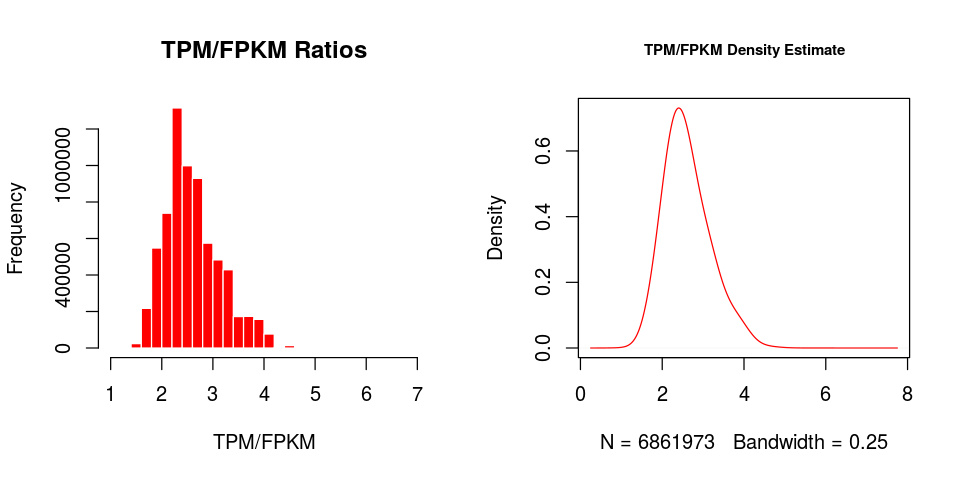

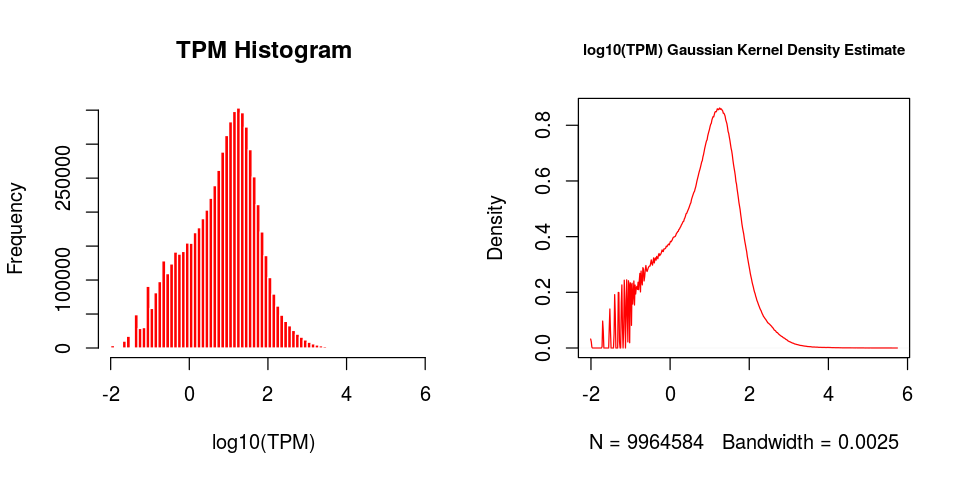

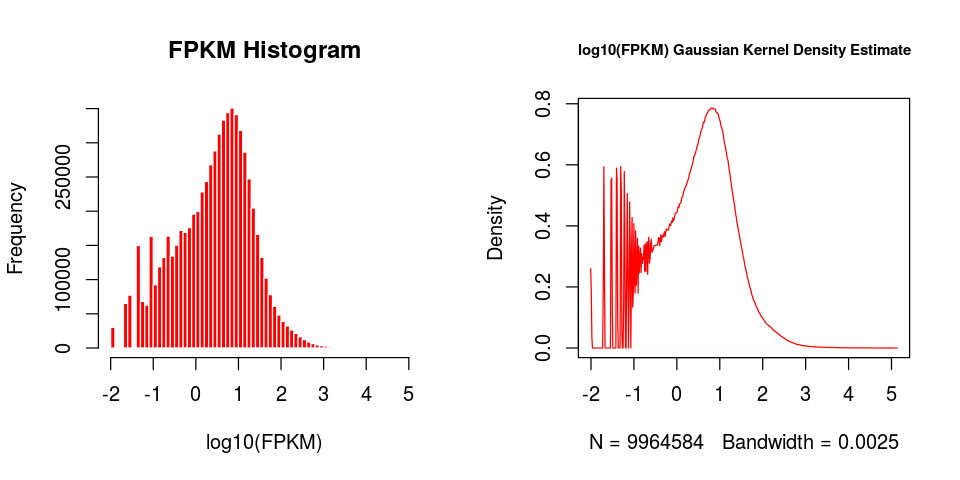

In [53]:
#Combine samples
fpkm <- cbind(fpkm.rsem.htsf$abundance, fpkm.rsem.tamu$abundance, fpkm.rsem.merge$abundance)
tpm <- cbind(tpm.rsem.htsf$abundance, tpm.rsem.tamu$abundance, tpm.rsem.merge$abundance)

#Sanity check that matrices are equal dimension
cat("FPKM matrix dimensions: ", dim(fpkm),"\n")
cat("TPM matrix dimensions: ", dim(tpm),"\n")

#Determine TPM to FPKM ratio for all samples and genes
ratios <- as.numeric(tpm/fpkm)
ratios <- na.omit(ratios)

#Generate correlation and ratio histogram
cat("TPM vs. FPKM Pearson Correlation: ", cor(x=as.numeric(tpm), y=as.numeric(fpkm)))
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
hist(ratios, breaks=40, border="white", col="red", main="TPM/FPKM Ratios", xlab="TPM/FPKM")
plot(density(ratios, kernel="gaussian", width=1), main="TPM/FPKM Density Estimate",
     col="red", lwd=1, cex.main=0.75)

#TPM Plots
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
hist(log10(as.numeric(tpm)), breaks=75,
     border="white", col="red", main="TPM Histogram", xlab="log10(TPM)")
plot(density(log10(as.numeric(tpm)), kernel="gaussian", width=0.01), main="log10(TPM) Gaussian Kernel Density Estimate",
     col="red", lwd=1, cex.main=0.75)

#FPKM Plots
par(mfrow=c(1,2))
hist(log10(as.numeric(fpkm)), breaks=75, 
     border="white", col="red", main="FPKM Histogram", xlab="log10(FPKM)")
plot(density(log10(as.numeric(fpkm)), kernel="gaussian", width=0.01), main="log10(FPKM) Gaussian Kernel Density Estimate",
     col="red", lwd=1, cex.main=0.75)

